In [26]:
# Variables
poblacion = []
tam_poblacion = 25
maximo_entradas = 25 # Esto va a depender de cuantos puntos definamos en la funcion
puntos_predecir = 5 # Cantidad de puntos a predecir
probabilidad_mutacion = 0.1 # Este no necesita explicacion

In [27]:
import random
import rbfn
import numpy as np
from sklearn.cluster import KMeans

def seleccion(poblacion):
    seleccionados = []
    #seleccionados.append(poblacion[0]) ete no va
    for n in range(1,len(poblacion)):
        seleccionados.append(poblacion[random.randrange(n)])
        # Para evitar cruzar un individuo consigo mismo
        # while ((n%2 == 1) and (seleccionados[n-1]["entradas"] == seleccionados[n]["entradas"])
        #     and (seleccionados[n-1]["hidden"] == seleccionados[n]["hidden"])):
        #    seleccionados[n] = poblacion[random.randrange(n)]
    return seleccionados

def cruza_uniforme(individuo_1, individuo_2):
    hijo_1 = {
        "entradas": 0,
        "hidden": 0,
        "centers": [],
        "mse" : -1.0
    }
    hijo_2 = {
        "entradas": 0,
        "hidden": 0,
        "centers": [],
        "mse" : -1.0
    }
    mask = random.randrange(maximo_entradas) # Numero entero entre 0 y 25
    # Calculo del primer hijo
    # Aplico mascara para un individuo y el complemento de la mascara al otro y sumo
    entradas_aux = (individuo_1["entradas"] & mask) + (individuo_2["entradas"] & ~mask)
    # Para que las entradas no sean mas que las definidas
    if (entradas_aux > maximo_entradas) : 
        entradas_aux = entradas_aux & maximo_entradas
    hidden_aux = (individuo_1["hidden"] & mask) + (individuo_2["hidden"] & ~mask)
    # Linea para la RBF consistente -> neuronas <= inputs
    if (hidden_aux > entradas_aux): hidden_aux =hidden_aux & entradas_aux
    hijo_1["entradas"] = entradas_aux
    hijo_1["hidden"] = hidden_aux 
    
    # Calculo del segundo hijo
    entradas_aux = (individuo_1["entradas"] & ~mask) + (individuo_2["entradas"] & mask)
    # Para que las entradas no sean mas que las definidas
    if (entradas_aux > maximo_entradas) : 
        entradas_aux = entradas_aux & maximo_entradas
    hidden_aux = (individuo_1["hidden"] & ~mask) + (individuo_2["hidden"] & mask)
    if (hidden_aux > entradas_aux): hidden_aux =hidden_aux & entradas_aux
    hijo_2["entradas"] = entradas_aux
    hijo_2["hidden"] = hidden_aux 
    
    # Este if es para que no se me creen hijos sin capa oculta o entradas
    if (hijo_1["hidden"] == 0 or hijo_2["hidden"] == 0) :
        return cruza_uniforme(individuo_1,individuo_2)
    return hijo_1,hijo_2

def mutacion(individuo):
    mask = random.randrange(maximo_entradas) # Numero entero entre 0 y 25
    # Aplico mascara para un individuo y el complemento de la mascara al otro y sumo
    entradas_aux = (individuo["entradas"] & ~mask) + (~individuo["entradas"] & mask)
    # Para que las entradas no sean mas que las definidas
    if (entradas_aux > maximo_entradas) : 
        entradas_aux = entradas_aux & maximo_entradas
    hidden_aux = (individuo["hidden"] & ~mask) + (~individuo["hidden"] & mask)
    # Linea para la RBF consistente -> neuronas <= inputs
    if (hidden_aux > entradas_aux): hidden_aux = hidden_aux & entradas_aux
    individuo["entradas"] = entradas_aux
    individuo["hidden"] = hidden_aux
    
    # If para que no se me mute a 0
    if (individuo["hidden"] == 0) : return mutacion(individuo)
    return individuo

# Funcion que utiliza para ordenar la lista
def fitness_sort(e):
    return e["mse"]


In [28]:
### CODIGO ###

# Definir la funcion que vamos a usar para prueba
x = np.linspace(-5, 5, 50).reshape(1,-1)
y = (2 * np.cos(x) + np.sin(3*x) + 5)



In [29]:
# Definir poblacion inicial
for i in range(1,tam_poblacion):
    aux = {
        "entradas": 1,
        "hidden": 1,
        "centers": [],
        "mse" : -1.0
    }
    aux_entradas = random.randrange(maximo_entradas) + 1
    aux_hidden = random.randrange(aux_entradas) + 1
    aux["entradas"] = aux_entradas # Asigno entradas
    aux["hidden"] = aux_hidden # Asigno neuronas
    # Calculo de los clusters del individuo
    model = KMeans(n_clusters= aux["hidden"])
    model.fit(x.T[-aux["entradas"]:]) 
    aux["centers"] = model.cluster_centers_ # Asigno centroides
    poblacion.append(aux)
    
# Calcular el fitness de la poblacion
for individuo in poblacion:
    x_test = x[0][-individuo["entradas"]-puntos_predecir:] # Esto es porque se genera un arreglo detro de otro
    y_test = y[0][-individuo["entradas"]-puntos_predecir:]
    x_aux = x_test[:individuo["entradas"]]
    y_aux = y_test[:individuo["entradas"]]
    individuo["mse"] = rbfn.calculo_mse(individuo["entradas"],individuo["hidden"],individuo["centers"],
            x_aux,y_aux,x_test,y_test)
    
# Ordenar poblacion por fitness
poblacion.sort(key=fitness_sort)

# Inicio Bucle - Condicion de finalizacion: la solucion no mejora en 3 iteraciones
mejores_individuos = [] # Lista de los mejores individuos 
mejor_individuo = poblacion[0] # Almacenar el mejor individuo de la poblacion (solo inicializo)
mejores_individuos.append(mejor_individuo)
mejor_solucion = 0 # Cuenta las iteraciones sin una mejor solucion
while mejor_solucion < 10 :        
    
    # Realizar seleccion
    print("Seleccionando\n")
    seleccionados = seleccion(poblacion)
    
    # Cruzar seleccion 
    print("Cruzando\n")
    hijos = []
    for i in range(1,len(seleccionados)):
        hijos.extend(cruza_uniforme(seleccionados[i-1],seleccionados[i]))
        i+=1
    
    # Probabilidad de mutacion
    #if (random.random() < probabilidad_mutacion) :
    #    print("Mutando\n")
    #    mutacion(hijos[random.randrange(len(hijos))])
    
    # Otra forma de mutar
    for i in hijos:
        if(random.random() < probabilidad_mutacion) :
            print("Mutando\n")
            mutacion(i)
    
    # Obtener centroides (model.get sentros)
    for individuo in hijos:
        model = KMeans(n_clusters= individuo["hidden"])
        model.fit(x.T[-individuo["entradas"]:]) 
        individuo["centers"] = model.cluster_centers_ # Asigno centroides
    
    # Calcular el fitness de los hijos
    print("Calculando Fitness\n")
    for individuo in hijos:
        x_test = x[0][-individuo["entradas"]-puntos_predecir:] # Esto es porque se genera un arreglo detro de otro
        y_test = y[0][-individuo["entradas"]-puntos_predecir:]
        x_aux = x_test[:individuo["entradas"]]
        y_aux = y_test[:individuo["entradas"]]
        individuo["mse"] = rbfn.calculo_mse(individuo["entradas"],individuo["hidden"],individuo["centers"],
            x_aux,y_aux,x_test,y_test)
    
    
    # Crear nueva poblacion
    print("Calculando nueva poblacion\n")
    poblacion.extend(hijos) # Agrego los hijos
    poblacion.sort(key=fitness_sort) # Ordeno por fitness
    poblacion = poblacion[:tam_poblacion] # Trunco la poblacion
    
    # Evaluo el mejor individuo para la condicion de parada
    if ((mejor_individuo["mse"] > poblacion[0]["mse"]) and poblacion[0]["mse"]!=-1) :
        mejor_individuo = poblacion[0]
        mejor_solucion = 0
        mejores_individuos.append(mejor_individuo)
    else:
        mejor_solucion+=1
    print("Mejor Fitness: ")
    print(mejor_individuo)
    print("\n")
    # Repite
print(mejor_individuo)

Seleccionando

Cruzando

Mutando

Mutando

Mutando

Mutando

Calculando Fitness

Calculando nueva poblacion

Mejor Fitness: 
{'entradas': 25, 'hidden': 5, 'centers': array([[1.63265306],
       [4.59183673],
       [0.51020408],
       [2.75510204],
       [3.67346939]]), 'mse': 0.660544922091758}


Seleccionando

Cruzando

Mutando

Mutando

Mutando

Calculando Fitness

Calculando nueva poblacion

Mejor Fitness: 
{'entradas': 25, 'hidden': 5, 'centers': array([[4.59183673],
       [2.55102041],
       [0.51020408],
       [3.57142857],
       [1.53061224]]), 'mse': 0.42551950947349104}


Seleccionando

Cruzando

Mutando

Mutando

Mutando

Mutando

Mutando

Mutando

Mutando

Mutando

Calculando Fitness

Calculando nueva poblacion

Mejor Fitness: 
{'entradas': 25, 'hidden': 5, 'centers': array([[3.57142857],
       [1.53061224],
       [2.55102041],
       [0.51020408],
       [4.59183673]]), 'mse': 0.4255195094734906}


Seleccionando

Cruzando

Mutando

Mutando

Mutando

Mutando

Mutand

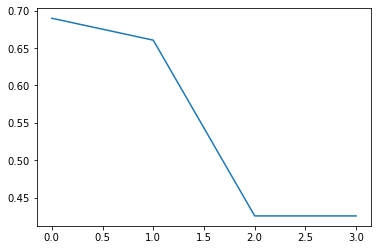

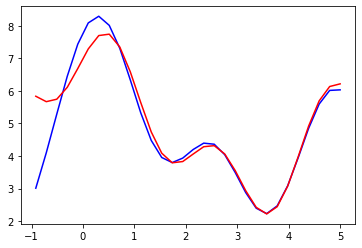

In [30]:
import matplotlib.pyplot as plt
lista_mse = []
lista_neuronas = []
for i in mejores_individuos:
    lista_neuronas.append([i["entradas"],i["hidden"]])
    lista_mse.append(i["mse"])
plt.plot(lista_mse)
plt.show()
x_test = x[0][-mejor_individuo["entradas"]-puntos_predecir:] # Esto es porque se genera un arreglo detro de otro
y_test = y[0][-mejor_individuo["entradas"]-puntos_predecir:]
x_aux = x_test[:mejor_individuo["entradas"]]
y_aux = y_test[:mejor_individuo["entradas"]]
rbfn.plotear_predicha(mejor_individuo["entradas"],mejor_individuo["hidden"],mejor_individuo["centers"],
            x_aux,y_aux,x_test,y_test)
